# Previous models were trained on noisy datasets. 
A method was used to clean out mis-labelled data from these datasets. This notebook trains on cleaned data. 

In [1]:
description = "Train on 2601 focal present and 2601 absent"

In [2]:
# !pip install wandb
# ! pip install wandb --upgrade

In [3]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [6]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [7]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, show_sample_from_df, clean_confidence_cats, get_recording_durations, plot_metrics_across_thresholds
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import glob
import sklearn
import ipywidgets as widgets

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"

# Log some hyperparameters

In [9]:
n_samples_per_class = 1700
one_output_neuron = True
random_seed = 42
learning_rate = 0.01
epochs=10

In [10]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [11]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

focal_df = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "focal_osfls_thresh_0.98_ngen_2601.pkl")

train_df.confidence_cat.value_counts()


confidence_cat
0     41658
3      1437
2       494
5       331
1       319
4        77
6        50
33        1
Name: count, dtype: int64

In [12]:
focal_df[['target_presence']] = 1.0
focal_df = focal_df[["target_presence"]]
focal_df.head()

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                   1.0
                                                   7.5        10.5                  1.0
                                                   13.5       16.5                  1.0
                                                   15.0       18.0                  1.0
                                                   24.0       27.0                  1.0

In [13]:
valid_df.value_counts()

target_absence  target_presence  confidence_cat
1.0             0.0              0                 9947
0.0             1.0              2                  360
                                 3                  357
                                 1                  296
                                 4                   28
                                 0                    2
Name: count, dtype: int64

In [14]:
train_df = clean_confidence_cats(train_df)
valid_df = clean_confidence_cats(valid_df)
train_df["target_absence"] = 1-train_df["target_presence"]
valid_df["target_absence"] = 1-valid_df["target_presence"]
train_df = train_df[["target_absence", "target_presence"]]
valid_df = valid_df[["target_absence", "target_presence"]]
train_df.value_counts(), valid_df.value_counts()

(target_absence  target_presence
 1.0             0.0                41770
 0.0             1.0                 1784
 Name: count, dtype: int64,
 target_absence  target_presence
 1.0             0.0                9947
 0.0             1.0                 387
 Name: count, dtype: int64)

# Remove invalid samples from invalid_samples.log

In [15]:
# read the contents of invalid_samples.log
with open("invalid_samples.log") as f:
    invalid_samples = f.readlines()
invalid_samples = [x.strip() for x in invalid_samples]
# convert to paths
invalid_samples = [Path(x) for x in invalid_samples]
# remove the invalid samples from the training set
train_df = train_df.drop(invalid_samples)

focal_df = focal_df.drop(invalid_samples)


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_18141/559495924.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_df = train_df.drop(invalid_samples)


KeyError: PosixPath('../../data/raw/recordings/OSFL/recording-104149.mp3')

In [16]:
invalid_samples

[PosixPath('../../data/raw/recordings/OSFL/recording-104149.mp3')]

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [17]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
# assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
# assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

3ed8d8c88668fa05ffc408bd1253447e13b41b0dd5dd77926d3490686deecdc7 d54f471abbc0d72e038b376de5896e0efd679391e1d531dd1b1f2f259e813d3c


In [18]:
zero_len_recordings = [Path('../../data/raw/recordings/OSFL/recording-565606.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565607.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565618.flac')],
      

drop_df = train_df.loc[zero_len_recordings]
train_df.drop(drop_df.index, inplace=True)

In [19]:
focal_df.target_presence.value_counts()

target_presence
1.0    2601
Name: count, dtype: int64

# Resample

In [20]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=380,random_state=random_seed)
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    1700
 1.0    1700
 Name: count, dtype: int64,
 3400)

In [21]:
# Sample as many focal samples as there are absent samples for  this experiment
absent = train_df[train_df.target_presence == 0]
present = focal_df
absent = absent.sample(len(present), random_state=random_seed)
present = present.sample(frac=1, random_state=random_seed)
train_df = pd.concat([absent[['target_presence']], present[['target_presence']]])
train_df.value_counts()


target_presence
0.0                2601
1.0                2601
Name: count, dtype: int64

In [22]:
train_df.head()

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-316166... 3.0        6.0                   0.0
../../data/raw/recordings/OSFL/recording-553577... 66.0       69.0                  0.0
../../data/raw/recordings/OSFL/recording-293857... 13.5       16.5                  0.0
../../data/raw/recordings/OSFL/recording-815868... 1.5        4.5                   0.0
../../data/raw/recordings/OSFL/recording-104216... 22.5       25.5                  0.0

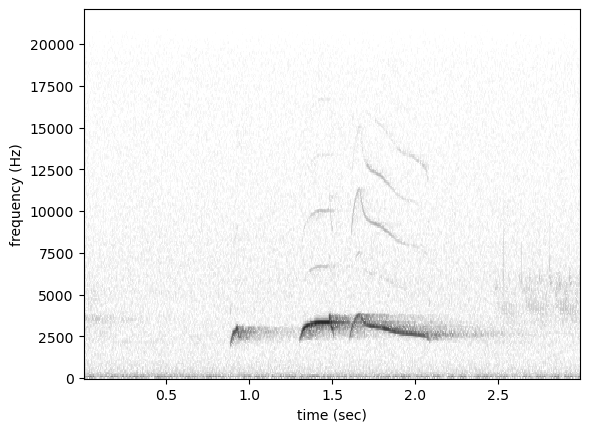

In [23]:
show_sample_from_df(train_df, 'present')

# Shuffle the training data

In [24]:
train_df = train_df.sample(frac=1)
balanced_valid_df = balanced_valid_df.sample(frac=1)

# Drop the redundant absence class

In [25]:
train_df = train_df[["target_presence"]]
balanced_valid_df = balanced_valid_df[["target_presence"]]
train_df.columns, balanced_valid_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

# Calculate recording durations for each recording in the training data
Some recordings might be corrupt and have zero samples. 

In [26]:
## Only need to do this if training fails due to zero length samples

# train_recording_durations = get_recording_durations(balanced_train_df)
# balanced_train_df['recording_duration'] = train_recording_durations
# balanced_train_df.loc[balanced_train_df['recording_duration'] < 3]

# Remove any additional invalid samples 
These may be printed during model training. 


In [27]:
def remove_files_from_df(df: pd.DataFrame, files: list):
    ''' 
    df must be a multi-indexed DataFrame with the first level being the file path.
    files is a list of string filepaths. 
    '''
    files = [Path(f) for f in files]
    df.drop(files, inplace=True)
    return df

In [28]:
short_samples = [("../../data/raw/recordings/OSFL/recording-293782.mp3"),
("../../data/raw/recordings/OSFL/recording-294264.mp3"),
("../../data/raw/recordings/OSFL/recording-292726.mp3"),
("../../data/raw/recordings/OSFL/recording-300271.mp3"),
("../../data/raw/recordings/OSFL/recording-296664.mp3"),]
train_df = remove_files_from_df(train_df, short_samples)

KeyError: PosixPath('../../data/raw/recordings/OSFL/recording-293782.mp3')

In [29]:
short_focal_samples = [("../../data/raw/recordings/OSFL/recording-538292.flac"),
("../../data/raw/recordings/OSFL/recording-255624.flac"),
("../../data/raw/recordings/OSFL/recording-255625.flac"),
("../../data/raw/recordings/OSFL/recording-168894.flac"),
("../../data/raw/recordings/OSFL/recording-104311.mp3"), 
("../../data/raw/recordings/OSFL/recording-100695.flac")]
train_df.drop(short_focal_samples, inplace=True)


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_18141/1701546307.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_df.drop(short_focal_samples, inplace=True)


In [30]:
len(train_df)

4572

In [31]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
    
)
# Set this to 'True' if there are more than one possible target class (present, absent, other) and only one label can be true. Set it to 'False' if there is only one output node - this will allow a threshold to be set on the output score and will allow use of sigmoid instead of softmax on the output layer. 
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

# Inspect the input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

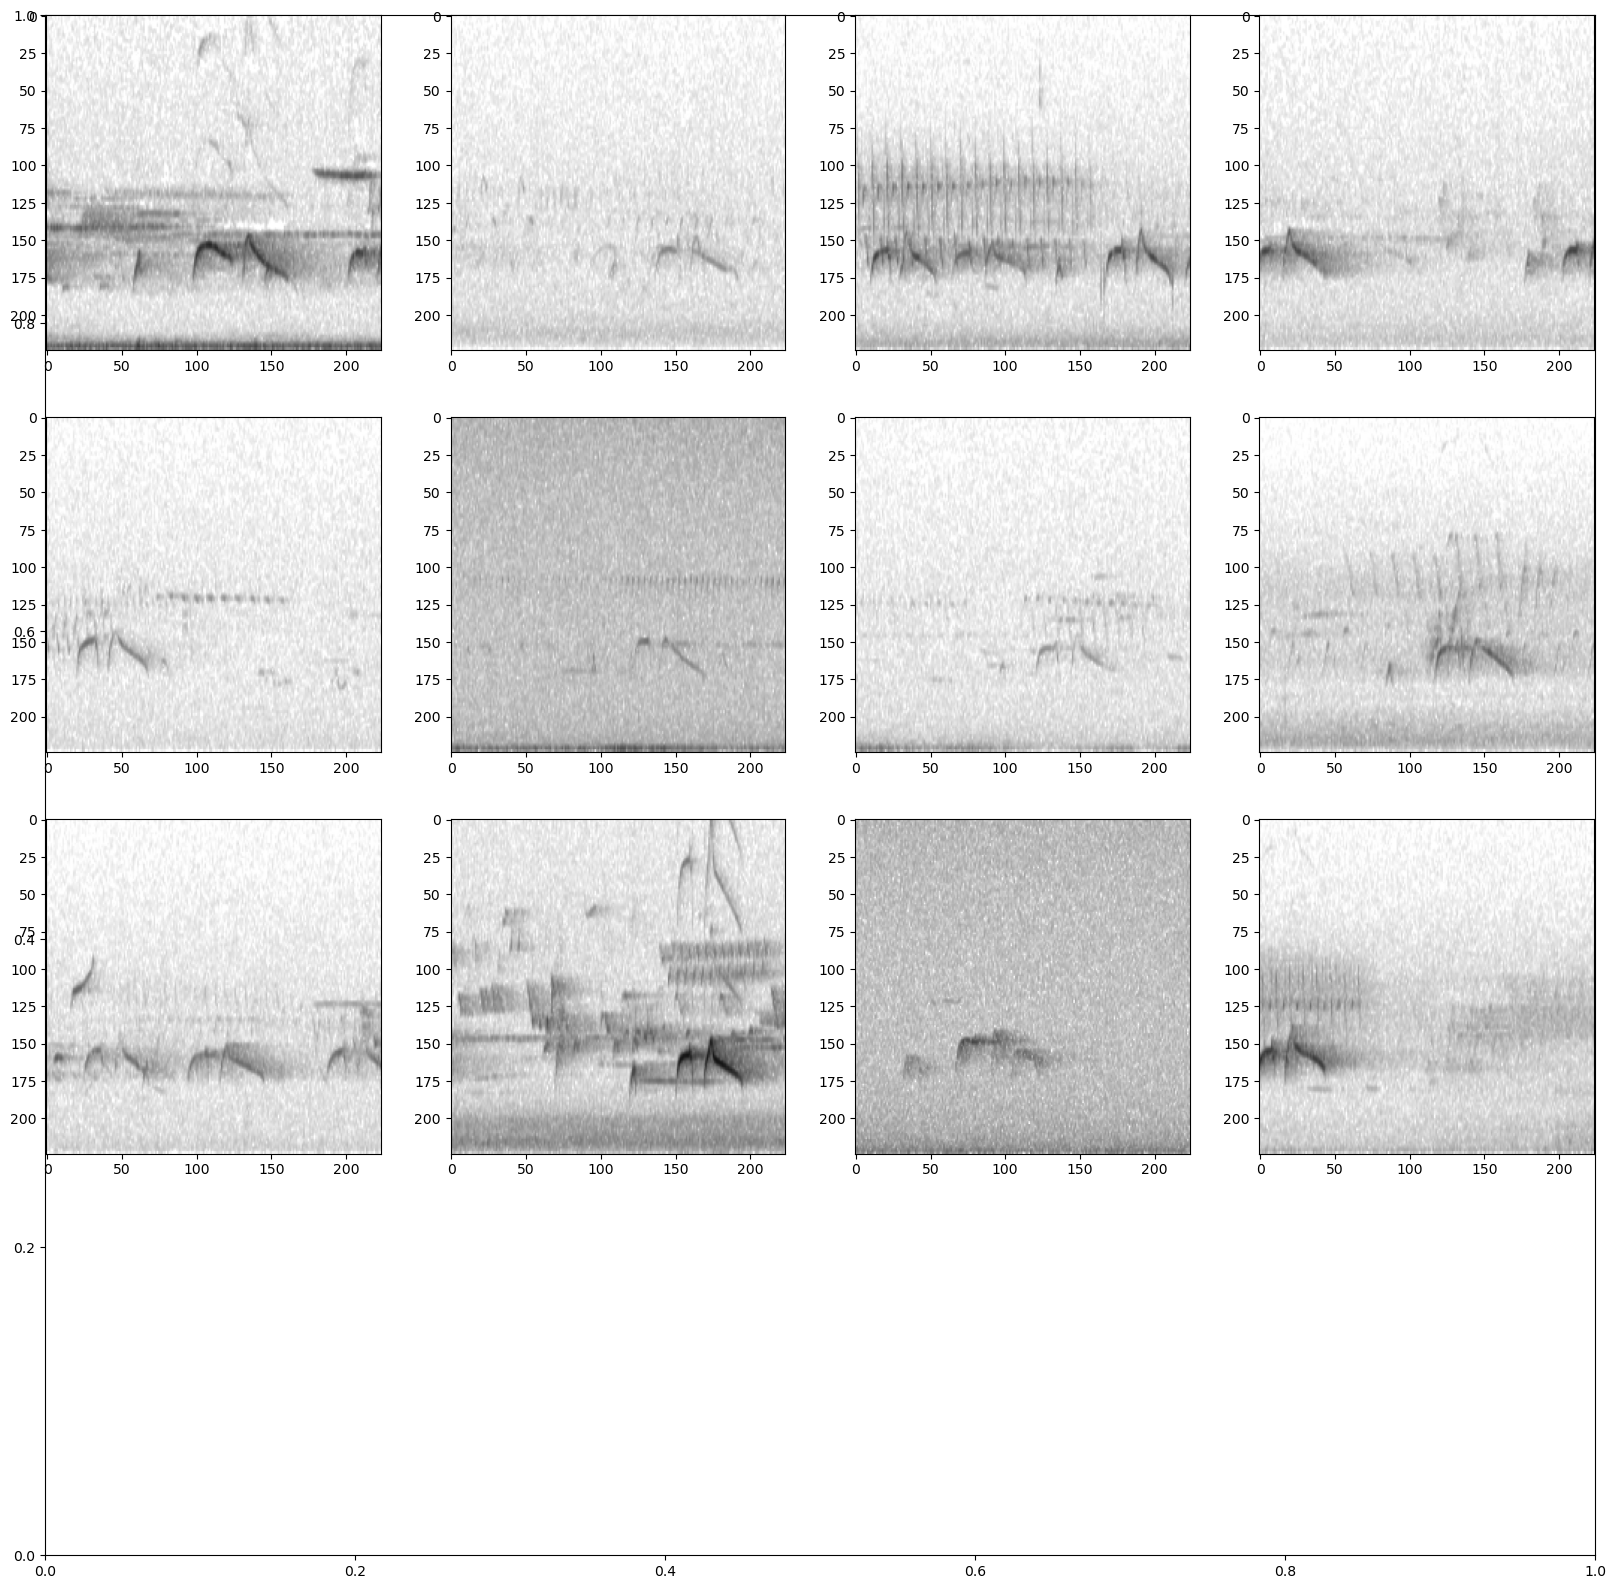

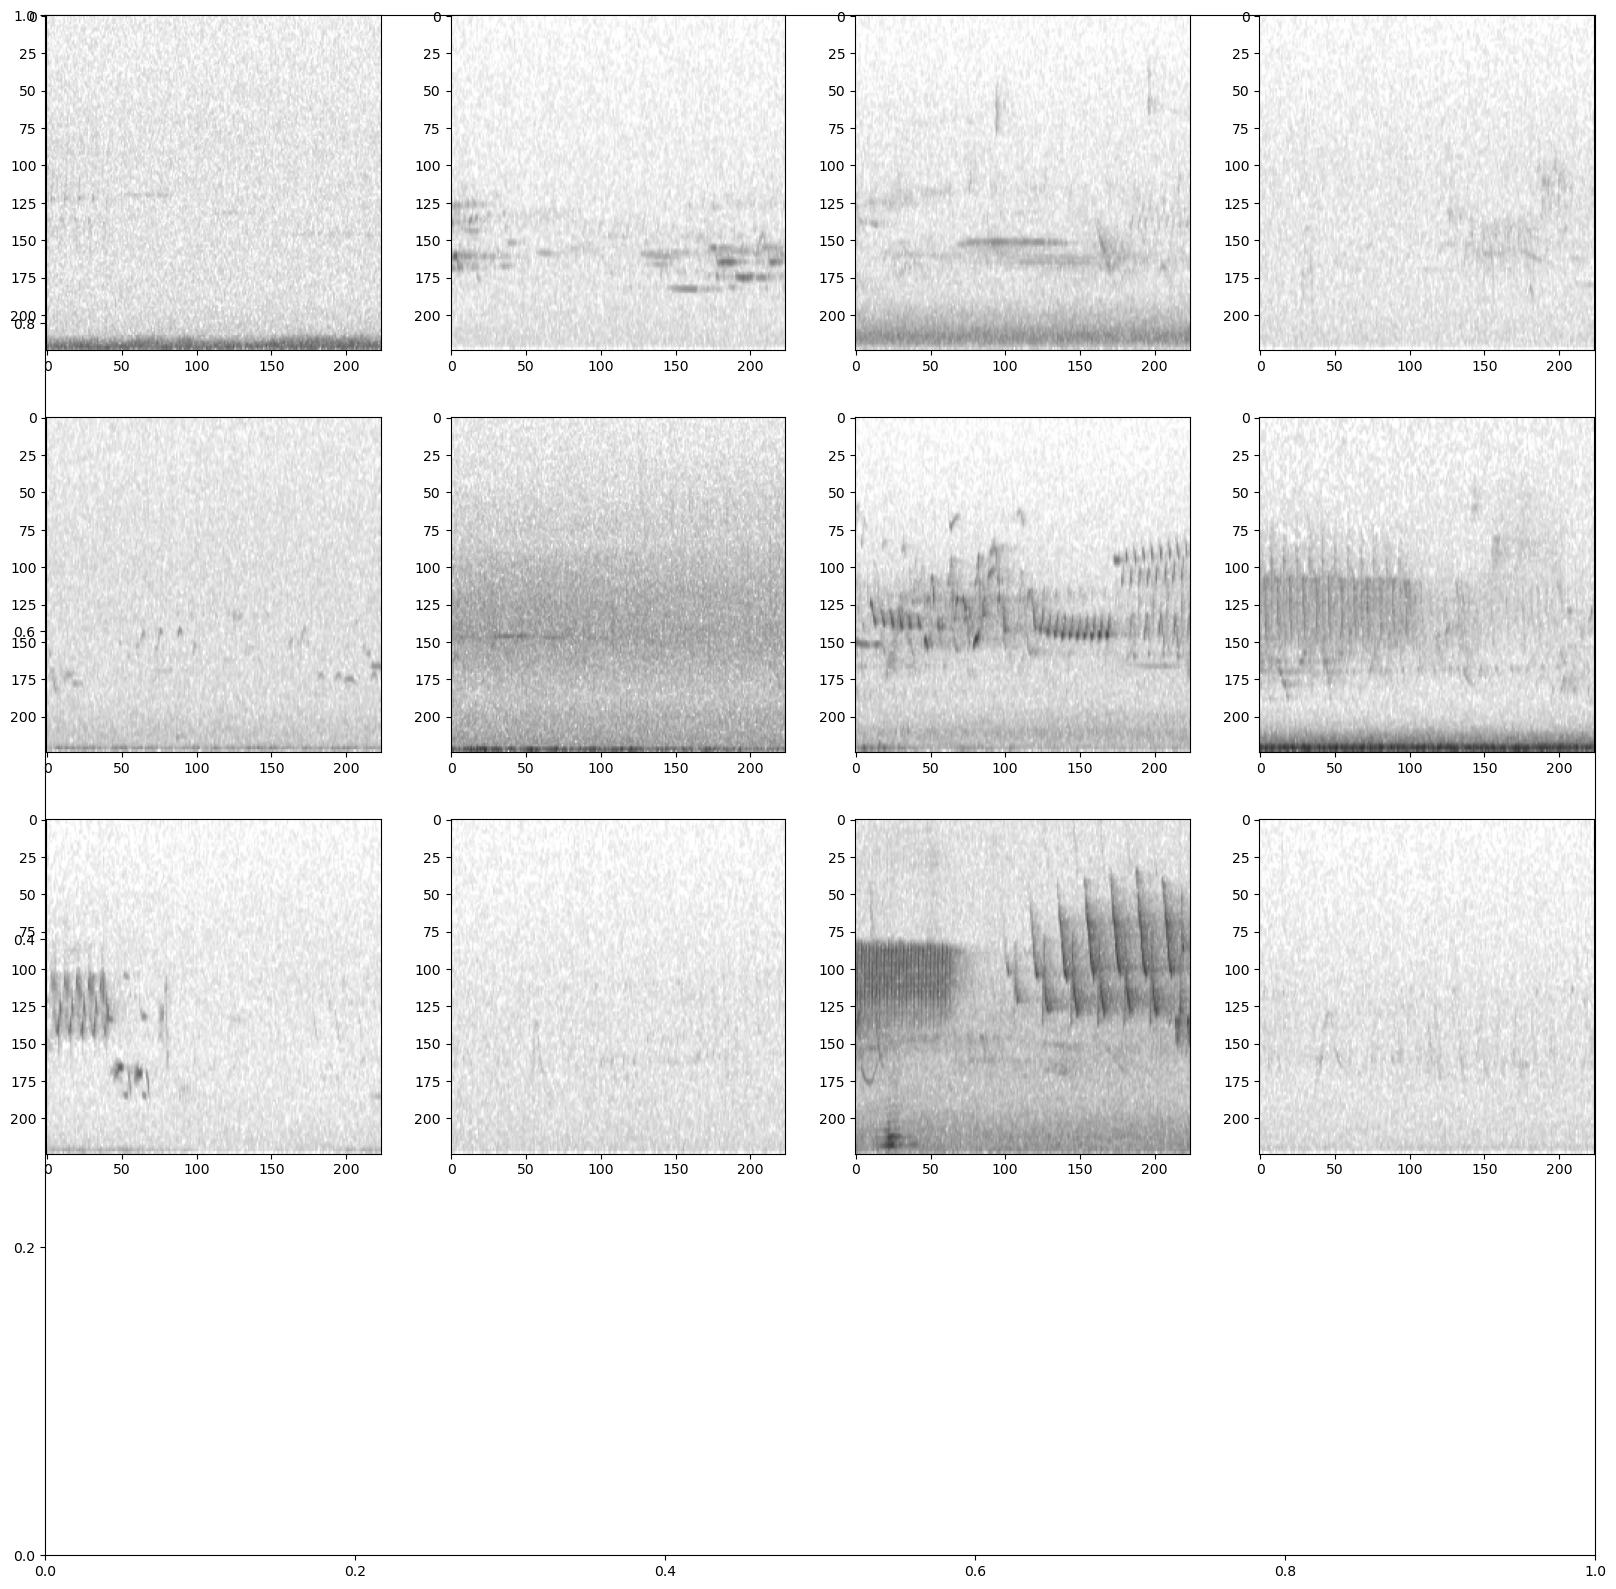

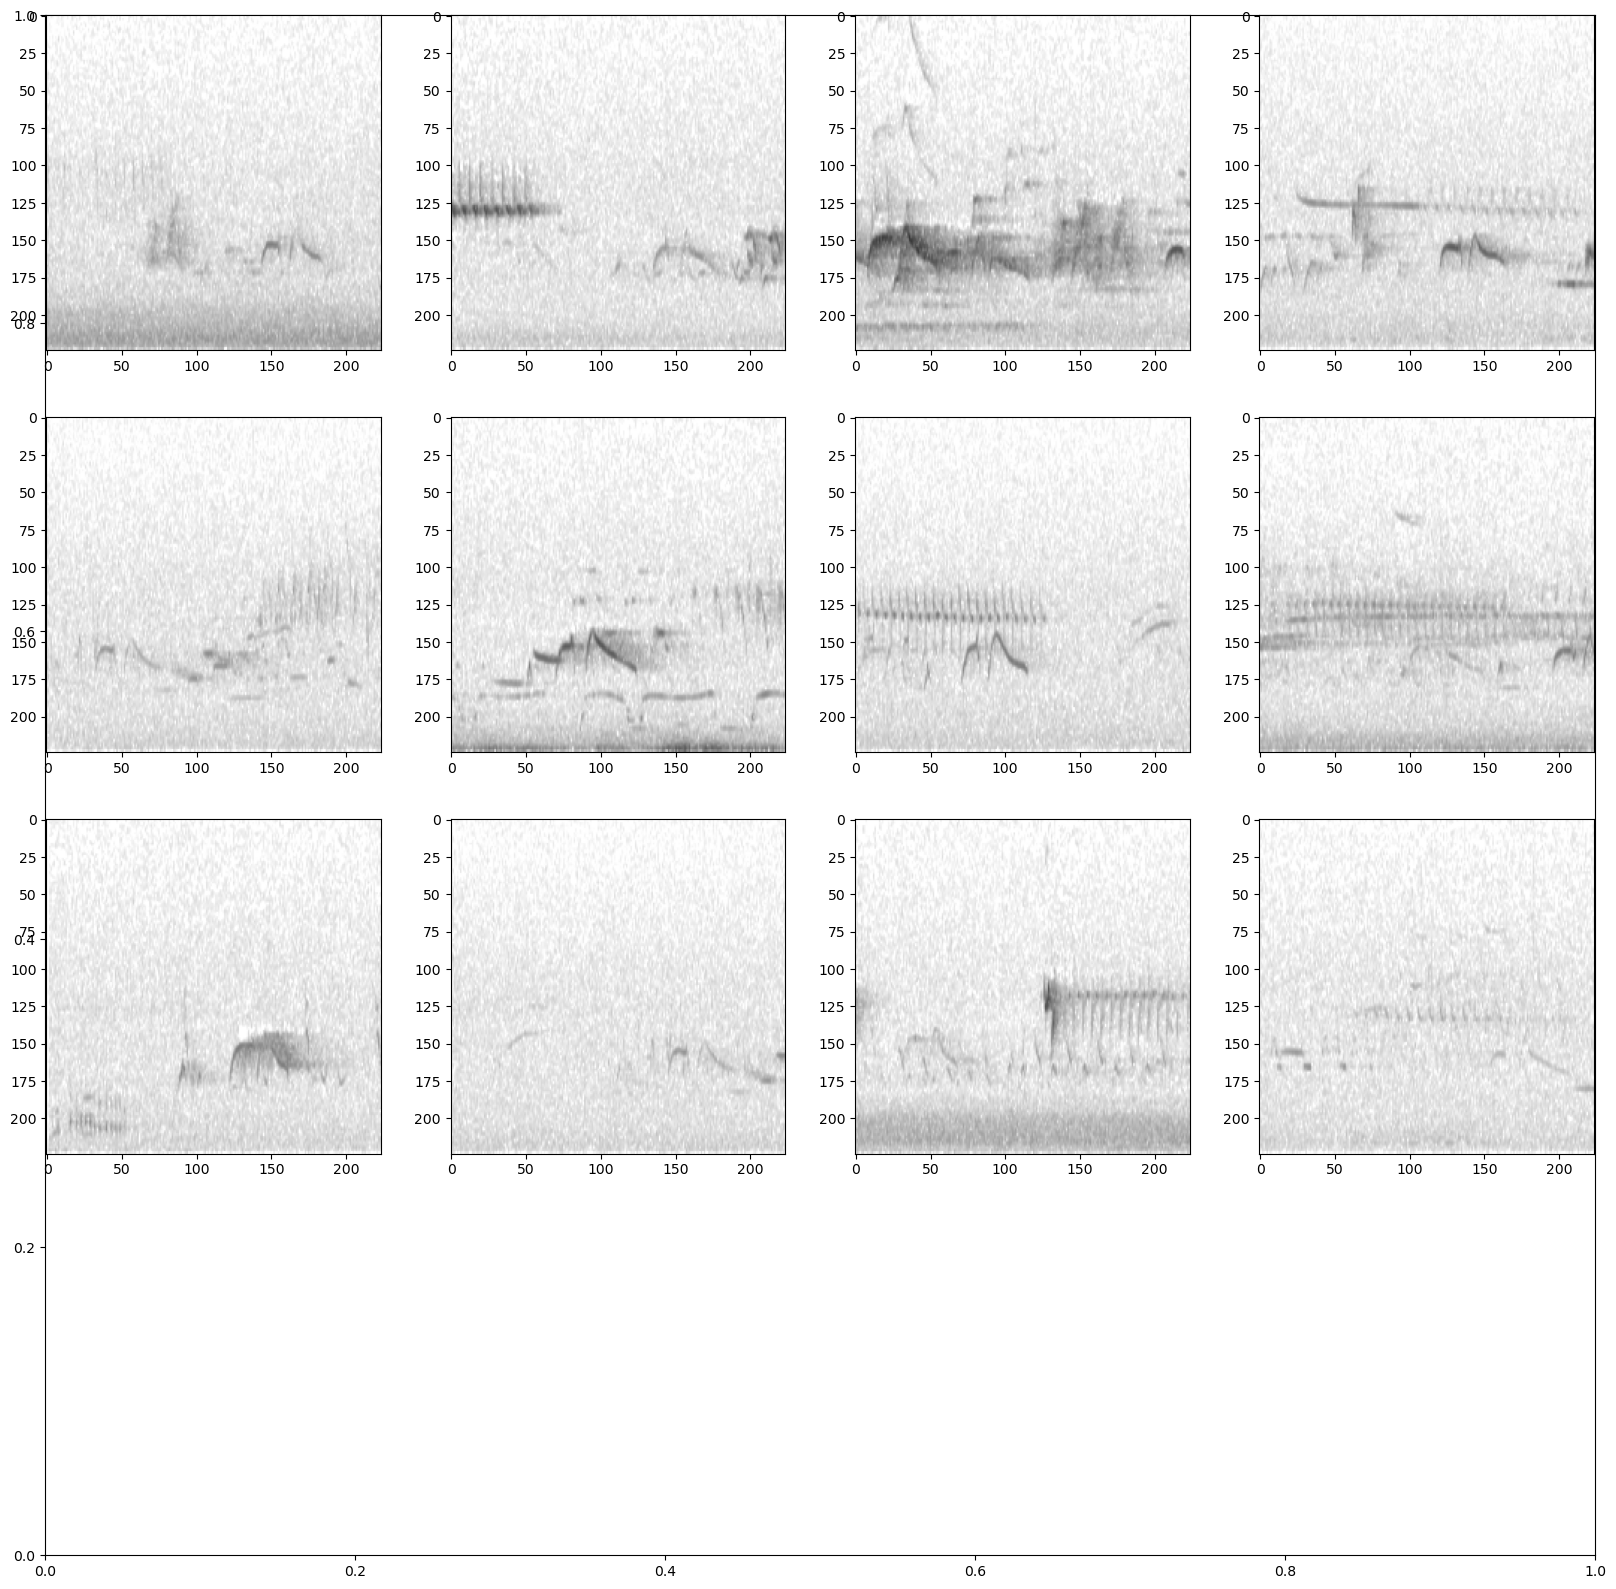

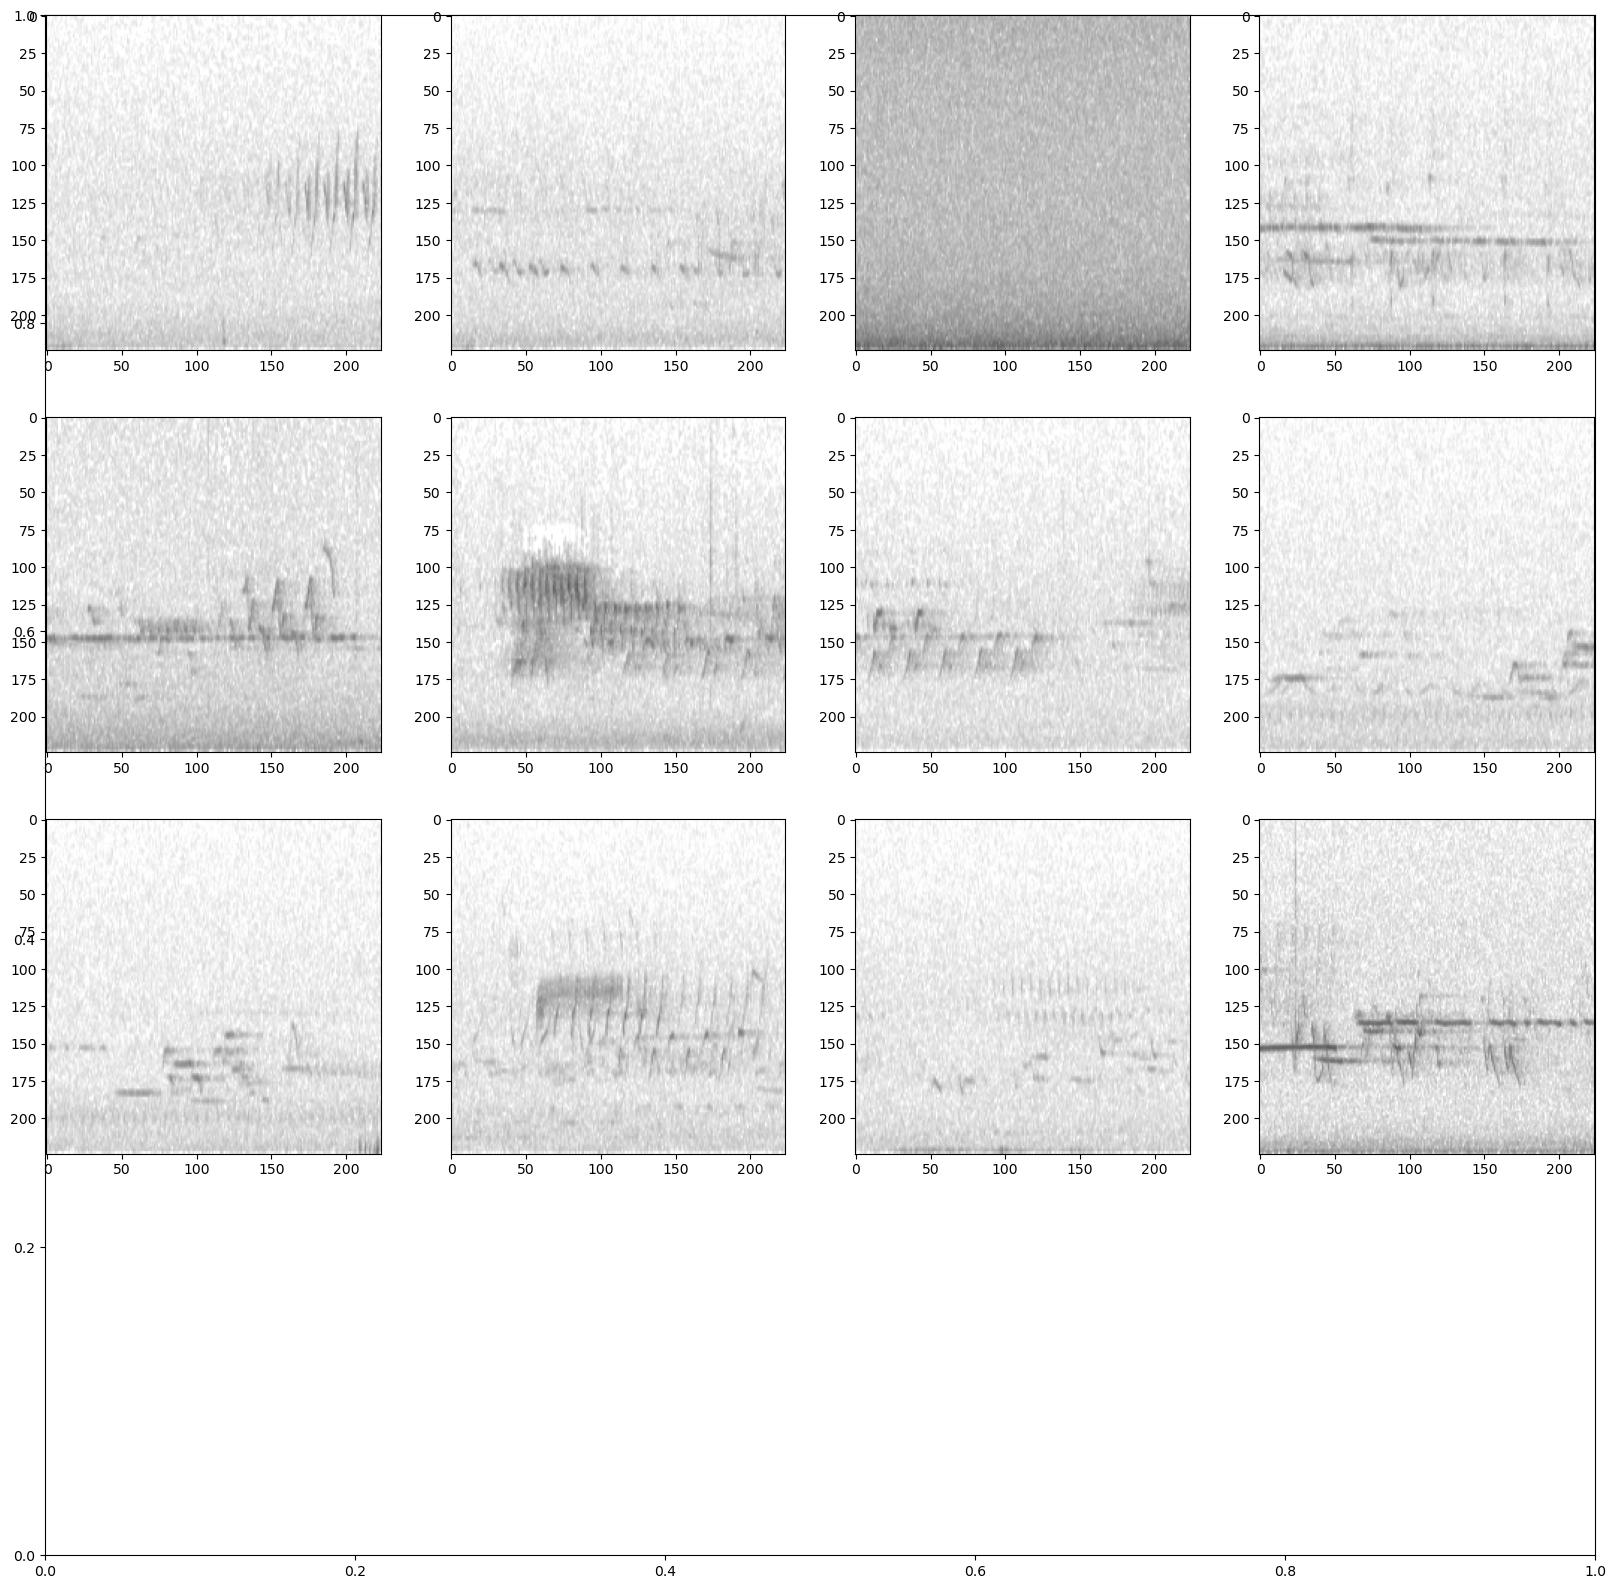

In [32]:
def inspect_input_samples(train_df, valid_df):
    present_t = train_df.loc[train_df.target_presence == 1]
    absent_t = train_df.loc[train_df.target_presence == 0]
    present_v = valid_df.loc[valid_df.target_presence == 1]
    absent_v = valid_df.loc[valid_df.target_presence == 0]

    # Generate a dataset with the samples we wish to inspect and the model's preprocessor
    for df in [present_t, absent_t, present_v, absent_v]:
        inspection_dataset = opso.AudioFileDataset(df.sample(12), model.preprocessor)
        inspection_dataset.bypass_augmentations = True

        samples = [sample.data for sample in inspection_dataset]
        _ = show_tensor_grid(samples, 4, invert=True)

inspect_input_samples(train_df, balanced_valid_df)


# Check for leakage

In [33]:
train_files = train_df.index.get_level_values("file")
valid_files = balanced_valid_df.index.get_level_values("file")
assert train_files.isin(valid_files).sum() == 0, "Train and validation sets have overlapping files"

In [34]:
model.optimizer_params['lr'] = learning_rate

In [35]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [36]:
class_list

['target_presence']

In [37]:
def show_sample_from_df(present=True, df = train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


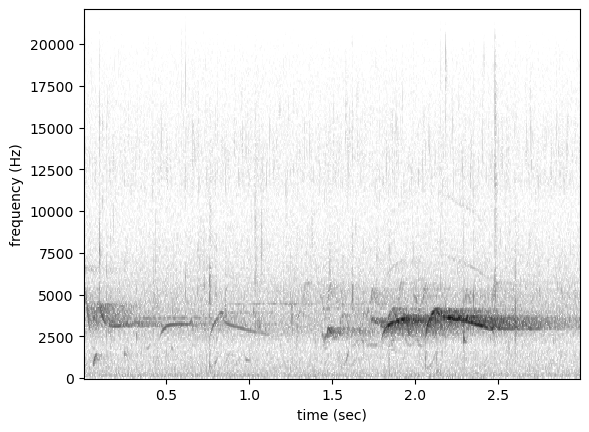

In [38]:
show_sample_from_df(present=True, df=train_df)


In [39]:
print(f'model.device is: {model.device}')

model.device is: mps


In [40]:
Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb"

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb')

In [41]:
%set_env WANDB_NOTEBOOK_NAME={Path(Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb")}

env: WANDB_NOTEBOOK_NAME=/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb


# Weights and biases initialization

In [42]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [43]:
balanced_valid_df.value_counts()


target_presence
0.0                380
1.0                380
Name: count, dtype: int64

In [44]:
train_df.value_counts()

target_presence
0.0                2601
1.0                1971
Name: count, dtype: int64

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
model.train(
    train_df,
    balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 2, #4 parallelized cpu tasks for preprocessing, Reduce if training quits unexpectedly
    log_interval = 10,
    save_interval = 1,
    invalid_samples_log='./invalid_training_samples.log',
    raise_errors=True,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 0 [batch 0/72, 0.00%] 
	DistLoss: 0.693
Metrics:
Epoch: 0 [batch 10/72, 13.89%] 
	DistLoss: 0.605
Metrics:
Epoch: 0 [batch 20/72, 27.78%] 
	DistLoss: 0.504
Metrics:
Epoch: 0 [batch 30/72, 41.67%] 
	DistLoss: 0.435
Metrics:
Epoch: 0 [batch 40/72, 55.56%] 
	DistLoss: 0.388
Metrics:
Epoch: 0 [batch 50/72, 69.44%] 
	DistLoss: 0.360
Metrics:
Epoch: 0 [batch 60/72, 83.33%] 
	DistLoss: 0.324
Metrics:
Epoch: 0 [batch 70/72, 97.22%] 
	DistLoss: 0.302
Metrics:
Metrics:
	MAP: 0.936

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.969

Training Epoch 1


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 1 [batch 0/72, 0.00%] 
	DistLoss: 0.118
Metrics:
Epoch: 1 [batch 10/72, 13.89%] 
	DistLoss: 0.150
Metrics:
Epoch: 1 [batch 20/72, 27.78%] 
	DistLoss: 0.169
Metrics:
Epoch: 1 [batch 30/72, 41.67%] 
	DistLoss: 0.168
Metrics:
Epoch: 1 [batch 40/72, 55.56%] 
	DistLoss: 0.169
Metrics:
Epoch: 1 [batch 50/72, 69.44%] 
	DistLoss: 0.162
Metrics:
Epoch: 1 [batch 60/72, 83.33%] 
	DistLoss: 0.162
Metrics:
Epoch: 1 [batch 70/72, 97.22%] 
	DistLoss: 0.155
Metrics:
Metrics:
	MAP: 0.982

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.989

Training Epoch 2


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 2 [batch 0/72, 0.00%] 
	DistLoss: 0.071
Metrics:
Epoch: 2 [batch 10/72, 13.89%] 
	DistLoss: 0.160
Metrics:
Epoch: 2 [batch 20/72, 27.78%] 
	DistLoss: 0.176
Metrics:
Epoch: 2 [batch 30/72, 41.67%] 
	DistLoss: 0.169
Metrics:
Epoch: 2 [batch 40/72, 55.56%] 
	DistLoss: 0.160
Metrics:
Epoch: 2 [batch 50/72, 69.44%] 
	DistLoss: 0.156
Metrics:
Epoch: 2 [batch 60/72, 83.33%] 
	DistLoss: 0.145
Metrics:
Epoch: 2 [batch 70/72, 97.22%] 
	DistLoss: 0.138
Metrics:
Metrics:
	MAP: 0.986

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.975

Training Epoch 3


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 3 [batch 0/72, 0.00%] 
	DistLoss: 0.103
Metrics:
Epoch: 3 [batch 10/72, 13.89%] 
	DistLoss: 0.127
Metrics:
Epoch: 3 [batch 20/72, 27.78%] 
	DistLoss: 0.108
Metrics:
Epoch: 3 [batch 30/72, 41.67%] 
	DistLoss: 0.107
Metrics:
Epoch: 3 [batch 40/72, 55.56%] 
	DistLoss: 0.109
Metrics:
Epoch: 3 [batch 50/72, 69.44%] 
	DistLoss: 0.116
Metrics:
Epoch: 3 [batch 60/72, 83.33%] 
	DistLoss: 0.117
Metrics:
Epoch: 3 [batch 70/72, 97.22%] 
	DistLoss: 0.114
Metrics:
Metrics:
	MAP: 0.990

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.987

Training Epoch 4


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 4 [batch 0/72, 0.00%] 
	DistLoss: 0.091
Metrics:
Epoch: 4 [batch 10/72, 13.89%] 
	DistLoss: 0.105
Metrics:
Epoch: 4 [batch 20/72, 27.78%] 
	DistLoss: 0.098
Metrics:
Epoch: 4 [batch 30/72, 41.67%] 
	DistLoss: 0.104
Metrics:
Epoch: 4 [batch 40/72, 55.56%] 
	DistLoss: 0.101
Metrics:
Epoch: 4 [batch 50/72, 69.44%] 
	DistLoss: 0.098
Metrics:
Epoch: 4 [batch 60/72, 83.33%] 
	DistLoss: 0.102
Metrics:
Epoch: 4 [batch 70/72, 97.22%] 
	DistLoss: 0.101
Metrics:
Metrics:
	MAP: 0.991

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.971

Training Epoch 5


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 5 [batch 0/72, 0.00%] 
	DistLoss: 0.079
Metrics:
Epoch: 5 [batch 10/72, 13.89%] 
	DistLoss: 0.115
Metrics:
Epoch: 5 [batch 20/72, 27.78%] 
	DistLoss: 0.103
Metrics:
Epoch: 5 [batch 30/72, 41.67%] 
	DistLoss: 0.102
Metrics:
Epoch: 5 [batch 40/72, 55.56%] 
	DistLoss: 0.104
Metrics:
Epoch: 5 [batch 50/72, 69.44%] 
	DistLoss: 0.103
Metrics:
Epoch: 5 [batch 60/72, 83.33%] 
	DistLoss: 0.101
Metrics:
Epoch: 5 [batch 70/72, 97.22%] 
	DistLoss: 0.098
Metrics:
Metrics:
	MAP: 0.992

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.979

Training Epoch 6


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 6 [batch 0/72, 0.00%] 
	DistLoss: 0.027
Metrics:
Epoch: 6 [batch 10/72, 13.89%] 
	DistLoss: 0.067
Metrics:
Epoch: 6 [batch 20/72, 27.78%] 
	DistLoss: 0.078
Metrics:
Epoch: 6 [batch 30/72, 41.67%] 
	DistLoss: 0.086
Metrics:
Epoch: 6 [batch 40/72, 55.56%] 
	DistLoss: 0.088
Metrics:
Epoch: 6 [batch 50/72, 69.44%] 
	DistLoss: 0.086
Metrics:
Epoch: 6 [batch 60/72, 83.33%] 
	DistLoss: 0.087
Metrics:
Epoch: 6 [batch 70/72, 97.22%] 
	DistLoss: 0.087
Metrics:
Metrics:
	MAP: 0.994

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.986

Training Epoch 7


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 7 [batch 0/72, 0.00%] 
	DistLoss: 0.220
Metrics:
Epoch: 7 [batch 10/72, 13.89%] 
	DistLoss: 0.115
Metrics:
Epoch: 7 [batch 20/72, 27.78%] 
	DistLoss: 0.113
Metrics:
Epoch: 7 [batch 30/72, 41.67%] 
	DistLoss: 0.103
Metrics:
Epoch: 7 [batch 40/72, 55.56%] 
	DistLoss: 0.102
Metrics:
Epoch: 7 [batch 50/72, 69.44%] 
	DistLoss: 0.101
Metrics:
Epoch: 7 [batch 60/72, 83.33%] 
	DistLoss: 0.096
Metrics:
Epoch: 7 [batch 70/72, 97.22%] 
	DistLoss: 0.095
Metrics:
Metrics:
	MAP: 0.992

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.983

Training Epoch 8


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 8 [batch 0/72, 0.00%] 
	DistLoss: 0.174
Metrics:
Epoch: 8 [batch 10/72, 13.89%] 
	DistLoss: 0.077
Metrics:
Epoch: 8 [batch 20/72, 27.78%] 
	DistLoss: 0.085
Metrics:
Epoch: 8 [batch 30/72, 41.67%] 
	DistLoss: 0.079
Metrics:
Epoch: 8 [batch 40/72, 55.56%] 
	DistLoss: 0.081
Metrics:
Epoch: 8 [batch 50/72, 69.44%] 
	DistLoss: 0.083
Metrics:
Epoch: 8 [batch 60/72, 83.33%] 
	DistLoss: 0.081
Metrics:
Epoch: 8 [batch 70/72, 97.22%] 
	DistLoss: 0.080
Metrics:
Metrics:
	MAP: 0.994

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.990

Training Epoch 9


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 9 [batch 0/72, 0.00%] 
	DistLoss: 0.171
Metrics:
Epoch: 9 [batch 10/72, 13.89%] 
	DistLoss: 0.090
Metrics:
Epoch: 9 [batch 20/72, 27.78%] 
	DistLoss: 0.087
Metrics:
Epoch: 9 [batch 30/72, 41.67%] 
	DistLoss: 0.076
Metrics:
Epoch: 9 [batch 40/72, 55.56%] 
	DistLoss: 0.079
Metrics:
Epoch: 9 [batch 50/72, 69.44%] 
	DistLoss: 0.079
Metrics:
Epoch: 9 [batch 60/72, 83.33%] 
	DistLoss: 0.079
Metrics:
Epoch: 9 [batch 70/72, 97.22%] 
	DistLoss: 0.079
Metrics:
Metrics:
	MAP: 0.994

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.983

Best Model Appears at Epoch 8 with Validation score 0.990.


In [47]:
# Load the checkpoint from the best epoch
model = opso.load_model("best.model")

# Show metrics per epoch

In [48]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.9635249307479224,
   'avg_precision': 0.9690030556877751,
   'precision': 0.8120950323974082,
   'recall': 0.9894736842105263,
   'f1': 0.8920521945432979,
   'support': 380},
  'precision': 0.8993135094646973,
  'recall': 0.8802631578947369,
  'f1': 0.878817825484352,
  'jaccard': 0.7840800098144183,
  'hamming_loss': 0.11973684210526316,
  'map': 0.9690030556877751,
  'au_roc': 0.9635249307479224},
 1: {'target_presence': {'au_roc': 0.9884833795013851,
   'avg_precision': 0.9888563067846735,
   'precision': 0.8577981651376146,
   'recall': 0.9842105263157894,
   'f1': 0.9166666666666665,
   'support': 380},
  'precision': 0.9196398233095481,
  'recall': 0.9105263157894736,
  'f1': 0.9100378787878787,
  'jaccard': 0.8349940215225189,
  'hamming_loss': 0.08947368421052632,
  'map': 0.9888563067846735,
  'au_roc': 0.9884833795013851},
 2: {'target_presence': {'au_roc': 0.9727908587257618,
   'avg_precision': 0.9753800365370362,
   'precision': 0.8189

In [49]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.939770852681061,
   'avg_precision': 0.9362442610670896,
   'precision': 0.8272546419098143,
   'recall': 0.9592464436755094,
   'f1': 0.8883745771764288,
   'support': 2601},
  'precision': 0.8795656242968095,
  'recall': 0.8474568088494239,
  'f1': 0.8553015500001793,
  'jaccard': 0.7486447461397319,
  'hamming_loss': 0.13713910761154854,
  'map': 0.9362442610670896,
  'au_roc': 0.939770852681061},
 1: {'target_presence': {'au_roc': 0.9822064299899484,
   'avg_precision': 0.9819783087097614,
   'precision': 0.9234414874225301,
   'recall': 0.9738562091503268,
   'f1': 0.9479790419161677,
   'support': 2601},
  'precision': 0.9431313506002754,
  'recall': 0.9336556540424389,
  'f1': 0.9374105735896627,
  'jaccard': 0.882380733295892,
  'hamming_loss': 0.06080489938757655,
  'map': 0.9819783087097614,
  'au_roc': 0.9822064299899484},
 2: {'target_presence': {'au_roc': 0.9872903350016998,
   'avg_precision': 0.9859185941722957,
   'precision': 0.9372

# Plot a confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

In [50]:
scores_df = model.predict(balanced_valid_df, activation_layer='sigmoid')

  0%|          | 0/760 [00:00<?, ?it/s]

In [51]:
def get_binary_predictions(target_df, model_predictions_df, threshold=0.5):
    '''
    Calculate the binary predictions needed for confusion matrix and other metrics. 
    target_df: DataFrame with labels in the target_presence column
    model_predictions_df: DataFrame with model predictions in target_presence column
    '''
    targets = target_df.target_presence.values
    scores = model_predictions_df.target_presence.values
    binary_preds = (scores > threshold).astype(float)
    return binary_preds, targets, scores


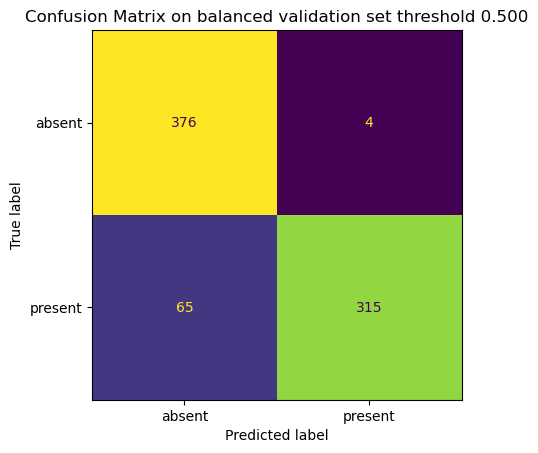

In [52]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(balanced_valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion Matrix on balanced validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Look at the metrics across thresholds
for the balanced validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


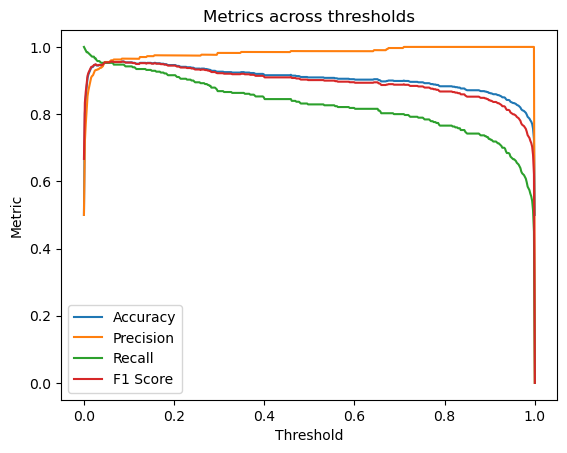

In [53]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

In [54]:
cm

array([[376,   4],
       [ 65, 315]])

In [55]:
# log confusion matrix to wandb as a table
wandb.log({"validation.confusion_matrix": cm})


In [56]:
def log_single_metric(metric, name):
    data = [[x, y] for (x, y) in zip(thresholds, metric)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            f"custom {name}": wandb.plot.line(
                table, "x", "y", title=f"Custom {name} vs threshold plot"
            )
        }
    )
log_single_metric(accuracies, "accuracy")
log_single_metric(precisions, "precision")
log_single_metric(recalls, "recall")
log_single_metric(f1s, "f1")


# Make predictions and plot confusion matrix on the full validation set
During training we only looked at a subset of the validation set values. 

In [57]:
scores_df = model.predict(valid_df, activation_layer='sigmoid')


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10334 [00:00<?, ?it/s]

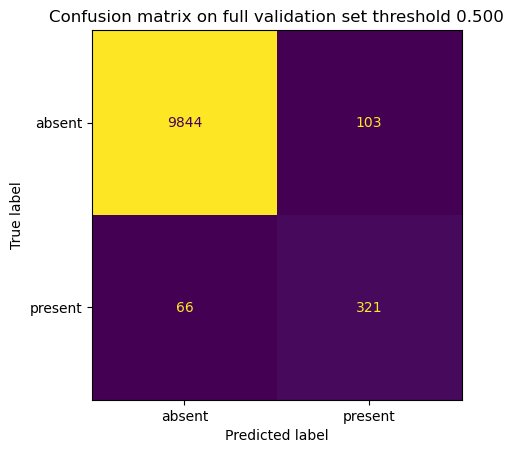

In [58]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Interactive confusion matrix


In [59]:

def show_cm(threshold):
    # Calculate the confusion matrix
    binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
    cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.4f}")
    cm_display.plot(ax=ax, colorbar=False)

from ipywidgets import interact
interact(show_cm, threshold=widgets.FloatSlider(min=0.0, max=1.0, step=0.0001, value=0.5))
# show_cm(0.5)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

<function __main__.show_cm(threshold)>

# Look at the metrics across thresholds
for the full validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


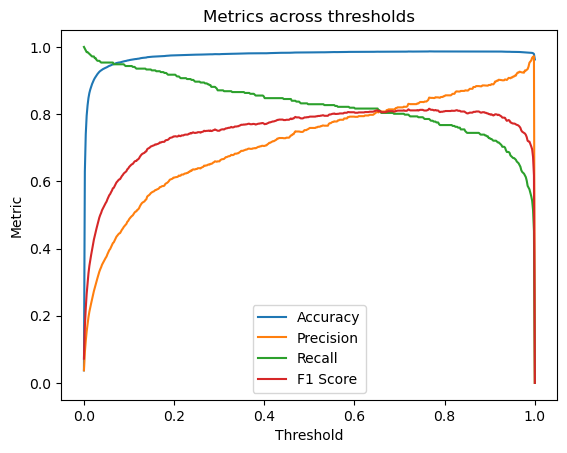

In [60]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

log_single_metric(accuracies, "accuracy_full_set")
log_single_metric(precisions, "precision_full_set")
log_single_metric(recalls, "recall_full_set")
log_single_metric(f1s, "f1_full_set")

# Result: 
Training on 1700 from each class produces a model with high precision and recall. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check. There you can load a pretrained model, make predictions on the validation set, and look at predictions in order of highest error for each class. 

# Save the best model to disk


In [63]:
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"{wandb.run.name}{1971_2601}.model")

In [62]:
train_df.value_counts()


target_presence
0.0                2601
1.0                1971
Name: count, dtype: int64

In [64]:
wandb.finish()

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore
